## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 100 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.8, 0.5, 0.1]
redice_lr_patient = [5, 10, 15]



In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                                  min_lr=1e-12, 
                                  monitor='val_loss', 
                                  patience=reduce_patient, 
                                  verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

W0426 11:25:10.916014  3068 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0426 11:25:10.917011  3068 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0426 11:25:10.919014  3068 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0426 11:25:10.988013  3068 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.



Numbers of exp: 0, reduce_factor: 0.80, reduce_patient: 5


W0426 11:25:11.170014  3068 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0426 11:25:11.177014  3068 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0426 11:25:11.259014  3068 deprecation.py:323] From D:\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

50000/50000 [==============================] - 2s 31us/step - loss: 0.6649 - acc: 0.7990 - val_loss: 1.5468 - val_acc: 0.4936
Epoch 47/100
50000/50000 [==============================] - 2s 31us/step - loss: 0.6566 - acc: 0.8019 - val_loss: 1.5569 - val_acc: 0.4933
Epoch 48/100
50000/50000 [==============================] - 2s 31us/step - loss: 0.6490 - acc: 0.8054 - val_loss: 1.5495 - val_acc: 0.4939
Epoch 49/100
50000/50000 [==============================] - 2s 31us/step - loss: 0.6413 - acc: 0.8081 - val_loss: 1.5558 - val_acc: 0.4904
Epoch 50/100
50000/50000 [==============================] - 2s 31us/step - loss: 0.6356 - acc: 0.8102 - val_loss: 1.5671 - val_acc: 0.4904

Epoch 00050: ReduceLROnPlateau reducing learning rate to 0.0002621440216898918.
Epoch 51/100
50000/50000 [==============================] - 2s 31us/step - loss: 0.6291 - acc: 0.8130 - val_loss: 1.5713 - val_acc: 0.4928
Epoch 52/100
50000/50000 [==============================] - 2s 31us/step - loss: 0.6223 - acc: 0.8

50000/50000 [==============================] - 2s 31us/step - loss: 0.5049 - acc: 0.8645 - val_loss: 1.6382 - val_acc: 0.4918
Epoch 100/100
50000/50000 [==============================] - 2s 31us/step - loss: 0.5039 - acc: 0.8652 - val_loss: 1.6377 - val_acc: 0.4923

Epoch 00100: ReduceLROnPlateau reducing learning rate to 2.8147498960606756e-05.
Numbers of exp: 1, reduce_factor: 0.80, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    

50000/50000 [==============================] - 2s 31us/step - loss: 1.6492 - acc: 0.4252 - val_loss: 1.7403 - val_acc: 0.3968
Epoch 47/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.6448 - acc: 0.4260 - val_loss: 1.7369 - val_acc: 0.3963
Epoch 48/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.6402 - acc: 0.4294 - val_loss: 1.7334 - val_acc: 0.3979
Epoch 49/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.6353 - acc: 0.4307 - val_loss: 1.7309 - val_acc: 0.3970
Epoch 50/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.6306 - acc: 0.4324 - val_loss: 1.7271 - val_acc: 0.3989
Epoch 51/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.6268 - acc: 0.4327 - val_loss: 1.7238 - val_acc: 0.3985
Epoch 52/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.6219 - acc: 0.4353 - val_loss: 1.7203 - val_acc: 0.3989
Epoch 53/100
50000/50000 [==============

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 2s 44us/step - loss: 2.7672 - acc: 0.1397 - val_loss: 2.6903 - val_acc: 0.1697
Epoch 2/100
50000/50000 [==============================] - 2s 31us/step - loss: 2.5297 - acc: 0.1900 - val_loss: 2.5488 - val_acc: 0.2091
Epoch 3/100
50000/50000 [==============================] - 2s 31us/step - loss: 2.3817 - acc: 0.2245 - val_loss: 2.3919 - val_acc: 0.2368
Epoch 4/100
50000/50000 [==============================] - 2s 31us/step - loss: 2.2881 - acc: 0.2460 - val_loss: 2.2938 - val_acc: 0.2568
Epoch 5/100
50000/50000 [==============================] - 2s 31us/step - loss: 2.2195 - acc: 0.2613 - val_loss: 2.2251 - val_acc: 0.2699
Epoch 6/100
50000/50000 [==============================] - 2s 31us/step - loss: 2.1659 - acc: 0.2747 - val_loss: 2.1748 - val_acc: 0.2803
Epoch 7/100
50000/50000 [==============================] - 2s 31us/step - loss: 2.1219 - acc: 0.2855 - val_loss: 2.1351 - 

50000/50000 [==============================] - 2s 31us/step - loss: 1.6077 - acc: 0.4395 - val_loss: 1.7029 - val_acc: 0.4107
Epoch 60/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.6041 - acc: 0.4409 - val_loss: 1.7001 - val_acc: 0.4103
Epoch 61/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.6006 - acc: 0.4417 - val_loss: 1.6976 - val_acc: 0.4116
Epoch 62/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.5970 - acc: 0.4432 - val_loss: 1.6953 - val_acc: 0.4127
Epoch 63/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.5933 - acc: 0.4444 - val_loss: 1.6929 - val_acc: 0.4123
Epoch 64/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.5908 - acc: 0.4455 - val_loss: 1.6904 - val_acc: 0.4133
Epoch 65/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.5866 - acc: 0.4473 - val_loss: 1.6884 - val_acc: 0.4152
Epoch 66/100
50000/50000 [==============

50000/50000 [==============================] - 2s 31us/step - loss: 2.1405 - acc: 0.2763 - val_loss: 2.1781 - val_acc: 0.2768
Epoch 8/100
50000/50000 [==============================] - 2s 31us/step - loss: 2.1005 - acc: 0.2890 - val_loss: 2.1369 - val_acc: 0.2866
Epoch 9/100
50000/50000 [==============================] - 2s 31us/step - loss: 2.0653 - acc: 0.2983 - val_loss: 2.1029 - val_acc: 0.2964
Epoch 10/100
50000/50000 [==============================] - 2s 31us/step - loss: 2.0358 - acc: 0.3048 - val_loss: 2.0748 - val_acc: 0.3030
Epoch 11/100
50000/50000 [==============================] - 2s 31us/step - loss: 2.0097 - acc: 0.3141 - val_loss: 2.0519 - val_acc: 0.3087
Epoch 12/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.9858 - acc: 0.3208 - val_loss: 2.0302 - val_acc: 0.3161
Epoch 13/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.9642 - acc: 0.3261 - val_loss: 2.0133 - val_acc: 0.3211
Epoch 14/100
50000/50000 [================

50000/50000 [==============================] - 2s 31us/step - loss: 1.5862 - acc: 0.4444 - val_loss: 1.7098 - val_acc: 0.4080
Epoch 67/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.5833 - acc: 0.4460 - val_loss: 1.7082 - val_acc: 0.4080
Epoch 68/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.5802 - acc: 0.4464 - val_loss: 1.7051 - val_acc: 0.4087
Epoch 69/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.5769 - acc: 0.4466 - val_loss: 1.7036 - val_acc: 0.4080
Epoch 70/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.5731 - acc: 0.4496 - val_loss: 1.7014 - val_acc: 0.4099
Epoch 71/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.5698 - acc: 0.4501 - val_loss: 1.6988 - val_acc: 0.4107
Epoch 72/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.5671 - acc: 0.4500 - val_loss: 1.6968 - val_acc: 0.4117
Epoch 73/100
50000/50000 [==============

50000/50000 [==============================] - 2s 31us/step - loss: 1.9543 - acc: 0.3281 - val_loss: 1.9971 - val_acc: 0.3188
Epoch 15/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.9367 - acc: 0.3337 - val_loss: 1.9821 - val_acc: 0.3214
Epoch 16/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.9201 - acc: 0.3388 - val_loss: 1.9679 - val_acc: 0.3276
Epoch 17/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.9044 - acc: 0.3422 - val_loss: 1.9552 - val_acc: 0.3305
Epoch 18/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.8914 - acc: 0.3455 - val_loss: 1.9430 - val_acc: 0.3339
Epoch 19/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.8779 - acc: 0.3501 - val_loss: 1.9307 - val_acc: 0.3372
Epoch 20/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.8654 - acc: 0.3543 - val_loss: 1.9203 - val_acc: 0.3402
Epoch 21/100
50000/50000 [==============

50000/50000 [==============================] - 2s 31us/step - loss: 1.5733 - acc: 0.4515 - val_loss: 1.6970 - val_acc: 0.4051
Epoch 74/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.5699 - acc: 0.4526 - val_loss: 1.6943 - val_acc: 0.4051
Epoch 75/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.5672 - acc: 0.4529 - val_loss: 1.6927 - val_acc: 0.4078
Epoch 76/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.5644 - acc: 0.4541 - val_loss: 1.6911 - val_acc: 0.4072
Epoch 77/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.5623 - acc: 0.4557 - val_loss: 1.6892 - val_acc: 0.4094
Epoch 78/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.5586 - acc: 0.4562 - val_loss: 1.6875 - val_acc: 0.4088
Epoch 79/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.5559 - acc: 0.4560 - val_loss: 1.6855 - val_acc: 0.4094
Epoch 80/100
50000/50000 [==============

50000/50000 [==============================] - 2s 31us/step - loss: 1.8350 - acc: 0.3656 - val_loss: 1.8935 - val_acc: 0.3482
Epoch 22/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.8244 - acc: 0.3687 - val_loss: 1.8831 - val_acc: 0.3507
Epoch 23/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.8136 - acc: 0.3710 - val_loss: 1.8743 - val_acc: 0.3537
Epoch 24/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.8035 - acc: 0.3740 - val_loss: 1.8659 - val_acc: 0.3566
Epoch 25/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.7950 - acc: 0.3766 - val_loss: 1.8580 - val_acc: 0.3598
Epoch 26/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.7853 - acc: 0.3802 - val_loss: 1.8504 - val_acc: 0.3620
Epoch 27/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.7766 - acc: 0.3828 - val_loss: 1.8429 - val_acc: 0.3640
Epoch 28/100
50000/50000 [==============

50000/50000 [==============================] - 2s 31us/step - loss: 1.5398 - acc: 0.4613 - val_loss: 1.6659 - val_acc: 0.4192
Epoch 81/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.5366 - acc: 0.4638 - val_loss: 1.6641 - val_acc: 0.4186
Epoch 82/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.5336 - acc: 0.4626 - val_loss: 1.6621 - val_acc: 0.4198
Epoch 83/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.5316 - acc: 0.4642 - val_loss: 1.6605 - val_acc: 0.4205
Epoch 84/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.5288 - acc: 0.4654 - val_loss: 1.6591 - val_acc: 0.4214
Epoch 85/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.5257 - acc: 0.4664 - val_loss: 1.6573 - val_acc: 0.4218
Epoch 86/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.5243 - acc: 0.4659 - val_loss: 1.6555 - val_acc: 0.4231
Epoch 87/100
50000/50000 [==============

50000/50000 [==============================] - 2s 31us/step - loss: 1.7787 - acc: 0.3829 - val_loss: 1.8495 - val_acc: 0.3632
Epoch 29/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.7701 - acc: 0.3849 - val_loss: 1.8430 - val_acc: 0.3656
Epoch 30/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.7635 - acc: 0.3890 - val_loss: 1.8372 - val_acc: 0.3666
Epoch 31/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.7550 - acc: 0.3911 - val_loss: 1.8308 - val_acc: 0.3679
Epoch 32/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.7471 - acc: 0.3942 - val_loss: 1.8256 - val_acc: 0.3678
Epoch 33/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.7414 - acc: 0.3963 - val_loss: 1.8203 - val_acc: 0.3695
Epoch 34/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.7343 - acc: 0.3981 - val_loss: 1.8152 - val_acc: 0.3710
Epoch 35/100
50000/50000 [==============

50000/50000 [==============================] - 2s 31us/step - loss: 1.5276 - acc: 0.4699 - val_loss: 1.6683 - val_acc: 0.4220
Epoch 88/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.5255 - acc: 0.4703 - val_loss: 1.6667 - val_acc: 0.4232
Epoch 89/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.5227 - acc: 0.4722 - val_loss: 1.6648 - val_acc: 0.4239
Epoch 90/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.5205 - acc: 0.4717 - val_loss: 1.6632 - val_acc: 0.4227
Epoch 91/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.5183 - acc: 0.4722 - val_loss: 1.6616 - val_acc: 0.4237
Epoch 92/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.5155 - acc: 0.4744 - val_loss: 1.6603 - val_acc: 0.4250
Epoch 93/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.5138 - acc: 0.4751 - val_loss: 1.6586 - val_acc: 0.4249
Epoch 94/100
50000/50000 [==============

50000/50000 [==============================] - 2s 31us/step - loss: 1.7205 - acc: 0.4029 - val_loss: 1.8127 - val_acc: 0.3723
Epoch 36/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.7134 - acc: 0.4040 - val_loss: 1.8079 - val_acc: 0.3733
Epoch 37/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.7084 - acc: 0.4082 - val_loss: 1.8037 - val_acc: 0.3741
Epoch 38/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.7024 - acc: 0.4093 - val_loss: 1.7985 - val_acc: 0.3749
Epoch 39/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.6974 - acc: 0.4109 - val_loss: 1.7951 - val_acc: 0.3781
Epoch 40/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.6911 - acc: 0.4125 - val_loss: 1.7908 - val_acc: 0.3792
Epoch 41/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.6855 - acc: 0.4137 - val_loss: 1.7863 - val_acc: 0.3796
Epoch 42/100
50000/50000 [==============

50000/50000 [==============================] - 2s 31us/step - loss: 1.5018 - acc: 0.4777 - val_loss: 1.6624 - val_acc: 0.4221
Epoch 95/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.4995 - acc: 0.4785 - val_loss: 1.6614 - val_acc: 0.4219
Epoch 96/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.4967 - acc: 0.4795 - val_loss: 1.6602 - val_acc: 0.4241
Epoch 97/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.4955 - acc: 0.4812 - val_loss: 1.6586 - val_acc: 0.4233
Epoch 98/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.4921 - acc: 0.4823 - val_loss: 1.6570 - val_acc: 0.4242
Epoch 99/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.4897 - acc: 0.4822 - val_loss: 1.6557 - val_acc: 0.4246
Epoch 100/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.4880 - acc: 0.4832 - val_loss: 1.6545 - val_acc: 0.4259
Numbers of exp: 8, reduce_factor: 0.10,

50000/50000 [==============================] - 2s 31us/step - loss: 1.6880 - acc: 0.4093 - val_loss: 1.7808 - val_acc: 0.3737
Epoch 43/100
50000/50000 [==============================] - 2s 32us/step - loss: 1.6833 - acc: 0.4096 - val_loss: 1.7766 - val_acc: 0.3752
Epoch 44/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.6778 - acc: 0.4122 - val_loss: 1.7732 - val_acc: 0.3772
Epoch 45/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.6732 - acc: 0.4139 - val_loss: 1.7692 - val_acc: 0.3781
Epoch 46/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.6686 - acc: 0.4156 - val_loss: 1.7658 - val_acc: 0.3785
Epoch 47/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.6630 - acc: 0.4170 - val_loss: 1.7620 - val_acc: 0.3814
Epoch 48/100
50000/50000 [==============================] - 2s 31us/step - loss: 1.6591 - acc: 0.4191 - val_loss: 1.7589 - val_acc: 0.3813
Epoch 49/100
50000/50000 [==============

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_28 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_29 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_30 (Batc (None, 128)               512       
__________

50000/50000 [==============================] - 2s 33us/step - loss: 0.0565 - acc: 0.9961 - val_loss: 2.3539 - val_acc: 0.5122
Epoch 46/100
50000/50000 [==============================] - 2s 33us/step - loss: 0.0533 - acc: 0.9967 - val_loss: 2.4083 - val_acc: 0.5117
Epoch 47/100
50000/50000 [==============================] - 2s 33us/step - loss: 0.0496 - acc: 0.9972 - val_loss: 2.3885 - val_acc: 0.5070
Epoch 48/100
50000/50000 [==============================] - 2s 33us/step - loss: 0.0475 - acc: 0.9975 - val_loss: 2.4163 - val_acc: 0.5067
Epoch 49/100
50000/50000 [==============================] - 2s 32us/step - loss: 0.0452 - acc: 0.9979 - val_loss: 2.4775 - val_acc: 0.5031

Epoch 00049: ReduceLROnPlateau reducing learning rate to 0.00016777217388153076.
Epoch 50/100
50000/50000 [==============================] - 2s 33us/step - loss: 0.0402 - acc: 0.9986 - val_loss: 2.4507 - val_acc: 0.5089
Epoch 51/100
50000/50000 [==============================] - 2s 33us/step - loss: 0.0382 - acc: 0.

50000/50000 [==============================] - 2s 34us/step - loss: 0.0126 - acc: 1.0000 - val_loss: 2.7694 - val_acc: 0.5135
Epoch 99/100
50000/50000 [==============================] - 2s 34us/step - loss: 0.0125 - acc: 1.0000 - val_loss: 2.7768 - val_acc: 0.5110

Epoch 00099: ReduceLROnPlateau reducing learning rate to 1.8014399392995985e-05.
Epoch 100/100
50000/50000 [==============================] - 2s 34us/step - loss: 0.0123 - acc: 0.9999 - val_loss: 2.7756 - val_acc: 0.5127
Numbers of exp: 10, reduce_factor: 0.80, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_31 (Batc (None, 512)               20

50000/50000 [==============================] - 2s 33us/step - loss: 0.9101 - acc: 0.7067 - val_loss: 1.4668 - val_acc: 0.4971
Epoch 46/100
50000/50000 [==============================] - 2s 33us/step - loss: 0.9028 - acc: 0.7112 - val_loss: 1.4620 - val_acc: 0.4959
Epoch 47/100
50000/50000 [==============================] - 2s 33us/step - loss: 0.8933 - acc: 0.7135 - val_loss: 1.4571 - val_acc: 0.4938
Epoch 48/100
50000/50000 [==============================] - 2s 33us/step - loss: 0.8866 - acc: 0.7177 - val_loss: 1.4623 - val_acc: 0.4963
Epoch 49/100
50000/50000 [==============================] - 2s 33us/step - loss: 0.8782 - acc: 0.7207 - val_loss: 1.4560 - val_acc: 0.4928

Epoch 00049: ReduceLROnPlateau reducing learning rate to 1.4411519805435093e-05.
Epoch 50/100
50000/50000 [==============================] - 2s 33us/step - loss: 0.8686 - acc: 0.7234 - val_loss: 1.4608 - val_acc: 0.4911
Epoch 51/100
50000/50000 [==============================] - 2s 33us/step - loss: 0.8607 - acc: 0.

50000/50000 [==============================] - 2s 33us/step - loss: 0.6698 - acc: 0.8067 - val_loss: 1.4998 - val_acc: 0.5041
Numbers of exp: 11, reduce_factor: 0.80, reduce_patient: 15
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_34 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_35 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense) 

50000/50000 [==============================] - 2s 33us/step - loss: 1.3075 - acc: 0.5519 - val_loss: 1.5538 - val_acc: 0.4617
Epoch 49/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.3027 - acc: 0.5536 - val_loss: 1.5513 - val_acc: 0.4627
Epoch 50/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.2991 - acc: 0.5556 - val_loss: 1.5505 - val_acc: 0.4632
Epoch 51/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.2941 - acc: 0.5581 - val_loss: 1.5479 - val_acc: 0.4639
Epoch 52/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.2898 - acc: 0.5594 - val_loss: 1.5468 - val_acc: 0.4643
Epoch 53/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.2857 - acc: 0.5598 - val_loss: 1.5458 - val_acc: 0.4670
Epoch 54/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.2802 - acc: 0.5630 - val_loss: 1.5449 - val_acc: 0.4663
Epoch 55/100
50000/50000 [==============

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 3s 65us/step - loss: 2.3328 - acc: 0.2393 - val_loss: 2.1275 - val_acc: 0.2926
Epoch 2/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.9504 - acc: 0.3354 - val_loss: 1.9614 - val_acc: 0.3330
Epoch 3/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.8419 - acc: 0.3669 - val_loss: 1.8930 - val_acc: 0.3491
Epoch 4/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.7808 - acc: 0.3850 - val_loss: 1.8404 - val_acc: 0.3679
Epoch 5/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.7370 - acc: 0.3980 - val_loss: 1.8029 - val_acc: 0.3776
Epoch 6/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.7035 - acc: 0.4106 - val_loss: 1.7792 - val_acc: 0.3840
Epoch 7/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.6765 - acc: 0.4186 - val_loss: 1.7579 - 

50000/50000 [==============================] - 2s 33us/step - loss: 1.2699 - acc: 0.5647 - val_loss: 1.5476 - val_acc: 0.4585
Epoch 60/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.2659 - acc: 0.5662 - val_loss: 1.5468 - val_acc: 0.4586
Epoch 61/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.2619 - acc: 0.5683 - val_loss: 1.5456 - val_acc: 0.4629
Epoch 62/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.2574 - acc: 0.5703 - val_loss: 1.5442 - val_acc: 0.4646
Epoch 63/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.2539 - acc: 0.5707 - val_loss: 1.5413 - val_acc: 0.4617
Epoch 64/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.2497 - acc: 0.5745 - val_loss: 1.5425 - val_acc: 0.4616
Epoch 65/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.2451 - acc: 0.5746 - val_loss: 1.5395 - val_acc: 0.4611
Epoch 66/100
50000/50000 [==============

50000/50000 [==============================] - 2s 33us/step - loss: 1.6595 - acc: 0.4202 - val_loss: 1.7372 - val_acc: 0.3990
Epoch 8/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.6361 - acc: 0.4274 - val_loss: 1.7170 - val_acc: 0.4055
Epoch 9/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.6169 - acc: 0.4349 - val_loss: 1.6997 - val_acc: 0.4080
Epoch 10/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.5978 - acc: 0.4414 - val_loss: 1.6895 - val_acc: 0.4135
Epoch 11/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.5815 - acc: 0.4485 - val_loss: 1.6765 - val_acc: 0.4180
Epoch 12/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.5672 - acc: 0.4529 - val_loss: 1.6653 - val_acc: 0.4213
Epoch 13/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.5530 - acc: 0.4573 - val_loss: 1.6590 - val_acc: 0.4245
Epoch 14/100
50000/50000 [================

50000/50000 [==============================] - 2s 33us/step - loss: 1.2298 - acc: 0.5798 - val_loss: 1.5107 - val_acc: 0.4702
Epoch 67/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.2257 - acc: 0.5819 - val_loss: 1.5094 - val_acc: 0.4694
Epoch 68/100
50000/50000 [==============================] - 2s 34us/step - loss: 1.2220 - acc: 0.5826 - val_loss: 1.5083 - val_acc: 0.4705
Epoch 69/100
50000/50000 [==============================] - 2s 34us/step - loss: 1.2181 - acc: 0.5844 - val_loss: 1.5058 - val_acc: 0.4718
Epoch 70/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.2147 - acc: 0.5857 - val_loss: 1.5056 - val_acc: 0.4697
Epoch 71/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.2108 - acc: 0.5878 - val_loss: 1.5064 - val_acc: 0.4724
Epoch 72/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.2066 - acc: 0.5891 - val_loss: 1.5047 - val_acc: 0.4733
Epoch 73/100
50000/50000 [==============

50000/50000 [==============================] - 2s 33us/step - loss: 1.5455 - acc: 0.4627 - val_loss: 1.6524 - val_acc: 0.4280
Epoch 15/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.5329 - acc: 0.4660 - val_loss: 1.6469 - val_acc: 0.4302
Epoch 16/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.5220 - acc: 0.4723 - val_loss: 1.6397 - val_acc: 0.4324
Epoch 17/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.5106 - acc: 0.4750 - val_loss: 1.6323 - val_acc: 0.4324
Epoch 18/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.5005 - acc: 0.4782 - val_loss: 1.6262 - val_acc: 0.4358
Epoch 19/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.4909 - acc: 0.4825 - val_loss: 1.6224 - val_acc: 0.4370
Epoch 20/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.4815 - acc: 0.4852 - val_loss: 1.6141 - val_acc: 0.4395
Epoch 21/100
50000/50000 [==============

50000/50000 [==============================] - 2s 33us/step - loss: 1.2044 - acc: 0.5907 - val_loss: 1.5010 - val_acc: 0.4761
Epoch 74/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.1997 - acc: 0.5925 - val_loss: 1.5032 - val_acc: 0.4763
Epoch 75/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.1963 - acc: 0.5937 - val_loss: 1.5007 - val_acc: 0.4777
Epoch 76/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.1935 - acc: 0.5950 - val_loss: 1.5016 - val_acc: 0.4788
Epoch 77/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.1897 - acc: 0.5967 - val_loss: 1.5006 - val_acc: 0.4777
Epoch 78/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.1855 - acc: 0.5978 - val_loss: 1.4994 - val_acc: 0.4786
Epoch 79/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.1834 - acc: 0.5994 - val_loss: 1.4990 - val_acc: 0.4787
Epoch 80/100
50000/50000 [==============

50000/50000 [==============================] - 2s 33us/step - loss: 1.4743 - acc: 0.4888 - val_loss: 1.6149 - val_acc: 0.4402
Epoch 22/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.4669 - acc: 0.4909 - val_loss: 1.6078 - val_acc: 0.4428
Epoch 23/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.4592 - acc: 0.4929 - val_loss: 1.6058 - val_acc: 0.4434
Epoch 24/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.4510 - acc: 0.4961 - val_loss: 1.6018 - val_acc: 0.4437
Epoch 25/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.4439 - acc: 0.5011 - val_loss: 1.5966 - val_acc: 0.4465
Epoch 26/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.4368 - acc: 0.5032 - val_loss: 1.5940 - val_acc: 0.4462
Epoch 27/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.4296 - acc: 0.5053 - val_loss: 1.5894 - val_acc: 0.4499
Epoch 28/100
50000/50000 [==============

50000/50000 [==============================] - 2s 33us/step - loss: 1.1899 - acc: 0.5966 - val_loss: 1.5060 - val_acc: 0.4784
Epoch 81/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.1871 - acc: 0.5980 - val_loss: 1.5054 - val_acc: 0.4810
Epoch 82/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.1831 - acc: 0.6003 - val_loss: 1.5046 - val_acc: 0.4797
Epoch 83/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.1803 - acc: 0.6017 - val_loss: 1.5042 - val_acc: 0.4803
Epoch 84/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.1764 - acc: 0.6018 - val_loss: 1.5028 - val_acc: 0.4831
Epoch 85/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.1730 - acc: 0.6054 - val_loss: 1.5043 - val_acc: 0.4809
Epoch 86/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.1702 - acc: 0.6053 - val_loss: 1.5011 - val_acc: 0.4809
Epoch 87/100
50000/50000 [==============

50000/50000 [==============================] - 2s 33us/step - loss: 1.4314 - acc: 0.5057 - val_loss: 1.6131 - val_acc: 0.4402
Epoch 29/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.4250 - acc: 0.5076 - val_loss: 1.6059 - val_acc: 0.4383
Epoch 30/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.4172 - acc: 0.5098 - val_loss: 1.6023 - val_acc: 0.4417
Epoch 31/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.4122 - acc: 0.5133 - val_loss: 1.6009 - val_acc: 0.4422
Epoch 32/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.4049 - acc: 0.5159 - val_loss: 1.5995 - val_acc: 0.4433
Epoch 33/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.4001 - acc: 0.5171 - val_loss: 1.5953 - val_acc: 0.4427
Epoch 34/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.3929 - acc: 0.5212 - val_loss: 1.5926 - val_acc: 0.4448
Epoch 35/100
50000/50000 [==============

50000/50000 [==============================] - 2s 33us/step - loss: 1.1671 - acc: 0.6084 - val_loss: 1.5238 - val_acc: 0.4717
Epoch 88/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.1646 - acc: 0.6086 - val_loss: 1.5229 - val_acc: 0.4712
Epoch 89/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.1603 - acc: 0.6081 - val_loss: 1.5222 - val_acc: 0.4740
Epoch 90/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.1584 - acc: 0.6104 - val_loss: 1.5212 - val_acc: 0.4723
Epoch 91/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.1544 - acc: 0.6115 - val_loss: 1.5197 - val_acc: 0.4722
Epoch 92/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.1511 - acc: 0.6135 - val_loss: 1.5193 - val_acc: 0.4712
Epoch 93/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.1473 - acc: 0.6146 - val_loss: 1.5191 - val_acc: 0.4726
Epoch 94/100
50000/50000 [==============

50000/50000 [==============================] - 2s 33us/step - loss: 1.3815 - acc: 0.5197 - val_loss: 1.5783 - val_acc: 0.4443
Epoch 36/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.3771 - acc: 0.5229 - val_loss: 1.5776 - val_acc: 0.4451
Epoch 37/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.3720 - acc: 0.5246 - val_loss: 1.5727 - val_acc: 0.4472
Epoch 38/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.3656 - acc: 0.5268 - val_loss: 1.5720 - val_acc: 0.4491
Epoch 39/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.3608 - acc: 0.5291 - val_loss: 1.5679 - val_acc: 0.4503
Epoch 40/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.3549 - acc: 0.5318 - val_loss: 1.5684 - val_acc: 0.4521
Epoch 41/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.3502 - acc: 0.5317 - val_loss: 1.5661 - val_acc: 0.4500
Epoch 42/100
50000/50000 [==============

50000/50000 [==============================] - 2s 33us/step - loss: 1.1403 - acc: 0.6156 - val_loss: 1.5081 - val_acc: 0.4711
Epoch 95/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.1372 - acc: 0.6168 - val_loss: 1.5095 - val_acc: 0.4699
Epoch 96/100
50000/50000 [==============================] - 2s 34us/step - loss: 1.1339 - acc: 0.6196 - val_loss: 1.5092 - val_acc: 0.4705
Epoch 97/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.1317 - acc: 0.6188 - val_loss: 1.5090 - val_acc: 0.4724
Epoch 98/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.1279 - acc: 0.6215 - val_loss: 1.5083 - val_acc: 0.4720
Epoch 99/100
50000/50000 [==============================] - 2s 34us/step - loss: 1.1245 - acc: 0.6220 - val_loss: 1.5060 - val_acc: 0.4719
Epoch 100/100
50000/50000 [==============================] - 2s 34us/step - loss: 1.1224 - acc: 0.6231 - val_loss: 1.5076 - val_acc: 0.4717
Numbers of exp: 18, reduce_factor: 0.80

50000/50000 [==============================] - 2s 32us/step - loss: 0.2534 - acc: 0.9320 - val_loss: 1.9799 - val_acc: 0.5066
Epoch 40/100
50000/50000 [==============================] - 2s 32us/step - loss: 0.2426 - acc: 0.9346 - val_loss: 2.0782 - val_acc: 0.4985
Epoch 41/100
50000/50000 [==============================] - 2s 33us/step - loss: 0.2310 - acc: 0.9397 - val_loss: 2.1621 - val_acc: 0.4895

Epoch 00041: ReduceLROnPlateau reducing learning rate to 0.0002621440216898918.
Epoch 42/100
50000/50000 [==============================] - 2s 33us/step - loss: 0.2041 - acc: 0.9519 - val_loss: 2.1674 - val_acc: 0.4960
Epoch 43/100
50000/50000 [==============================] - 2s 32us/step - loss: 0.1931 - acc: 0.9551 - val_loss: 2.0996 - val_acc: 0.5057
Epoch 44/100
50000/50000 [==============================] - 2s 32us/step - loss: 0.1839 - acc: 0.9570 - val_loss: 2.2580 - val_acc: 0.4902
Epoch 45/100
50000/50000 [==============================] - 2s 32us/step - loss: 0.1761 - acc: 0.9

50000/50000 [==============================] - 2s 32us/step - loss: 0.0238 - acc: 0.9996 - val_loss: 2.8598 - val_acc: 0.5075
Epoch 93/100
50000/50000 [==============================] - 2s 32us/step - loss: 0.0231 - acc: 0.9996 - val_loss: 2.8662 - val_acc: 0.5124
Epoch 94/100
50000/50000 [==============================] - 2s 32us/step - loss: 0.0227 - acc: 0.9997 - val_loss: 2.8841 - val_acc: 0.5092
Epoch 95/100
50000/50000 [==============================] - 2s 32us/step - loss: 0.0223 - acc: 0.9997 - val_loss: 2.8973 - val_acc: 0.5068
Epoch 96/100
50000/50000 [==============================] - 2s 33us/step - loss: 0.0224 - acc: 0.9998 - val_loss: 2.8866 - val_acc: 0.5137

Epoch 00096: ReduceLROnPlateau reducing learning rate to 2.25179988774471e-05.
Epoch 97/100
50000/50000 [==============================] - 2s 33us/step - loss: 0.0214 - acc: 0.9997 - val_loss: 2.8956 - val_acc: 0.5069
Epoch 98/100
50000/50000 [==============================] - 2s 33us/step - loss: 0.0211 - acc: 0.99

50000/50000 [==============================] - 2s 33us/step - loss: 1.0016 - acc: 0.6687 - val_loss: 1.4953 - val_acc: 0.4894
Epoch 40/100
50000/50000 [==============================] - 2s 33us/step - loss: 0.9893 - acc: 0.6741 - val_loss: 1.4926 - val_acc: 0.4906
Epoch 41/100
50000/50000 [==============================] - 2s 33us/step - loss: 0.9802 - acc: 0.6764 - val_loss: 1.4844 - val_acc: 0.4930
Epoch 42/100
50000/50000 [==============================] - 2s 33us/step - loss: 0.9693 - acc: 0.6824 - val_loss: 1.4926 - val_acc: 0.4895
Epoch 43/100
50000/50000 [==============================] - 2s 33us/step - loss: 0.9586 - acc: 0.6872 - val_loss: 1.5056 - val_acc: 0.4862
Epoch 44/100
50000/50000 [==============================] - 2s 32us/step - loss: 0.9479 - acc: 0.6913 - val_loss: 1.4929 - val_acc: 0.4914
Epoch 45/100
50000/50000 [==============================] - 2s 32us/step - loss: 0.9381 - acc: 0.6948 - val_loss: 1.4978 - val_acc: 0.4897
Epoch 46/100
50000/50000 [==============

50000/50000 [==============================] - 2s 32us/step - loss: 0.6356 - acc: 0.8204 - val_loss: 1.5454 - val_acc: 0.4897
Epoch 96/100
50000/50000 [==============================] - 2s 33us/step - loss: 0.6322 - acc: 0.8216 - val_loss: 1.5472 - val_acc: 0.4937
Epoch 97/100
50000/50000 [==============================] - 2s 33us/step - loss: 0.6295 - acc: 0.8227 - val_loss: 1.5477 - val_acc: 0.4939
Epoch 98/100
50000/50000 [==============================] - 2s 32us/step - loss: 0.6271 - acc: 0.8247 - val_loss: 1.5481 - val_acc: 0.4948
Epoch 99/100
50000/50000 [==============================] - 2s 32us/step - loss: 0.6246 - acc: 0.8255 - val_loss: 1.5492 - val_acc: 0.4932
Epoch 100/100
50000/50000 [==============================] - 2s 33us/step - loss: 0.6208 - acc: 0.8255 - val_loss: 1.5491 - val_acc: 0.4937
Numbers of exp: 20, reduce_factor: 0.80, reduce_patient: 15
_________________________________________________________________
Layer (type)                 Output Shape           

50000/50000 [==============================] - 2s 32us/step - loss: 1.3215 - acc: 0.5433 - val_loss: 1.5558 - val_acc: 0.4544
Epoch 44/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.3154 - acc: 0.5469 - val_loss: 1.5552 - val_acc: 0.4547
Epoch 45/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.3083 - acc: 0.5504 - val_loss: 1.5582 - val_acc: 0.4530
Epoch 46/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.3024 - acc: 0.5522 - val_loss: 1.5474 - val_acc: 0.4574
Epoch 47/100
50000/50000 [==============================] - 2s 32us/step - loss: 1.2966 - acc: 0.5539 - val_loss: 1.5509 - val_acc: 0.4543
Epoch 48/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.2901 - acc: 0.5562 - val_loss: 1.5506 - val_acc: 0.4561
Epoch 49/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.2829 - acc: 0.5597 - val_loss: 1.5427 - val_acc: 0.4558
Epoch 50/100
50000/50000 [==============

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 4s 79us/step - loss: 2.5595 - acc: 0.1818 - val_loss: 2.4275 - val_acc: 0.2302
Epoch 2/100
50000/50000 [==============================] - 2s 32us/step - loss: 2.2317 - acc: 0.2550 - val_loss: 2.2336 - val_acc: 0.2786
Epoch 3/100
50000/50000 [==============================] - 2s 32us/step - loss: 2.0773 - acc: 0.2939 - val_loss: 2.1005 - val_acc: 0.3019
Epoch 4/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.9799 - acc: 0.3205 - val_loss: 2.0073 - val_acc: 0.3221
Epoch 5/100
50000/50000 [==============================] - 2s 32us/step - loss: 1.9087 - acc: 0.3418 - val_loss: 1.9508 - val_acc: 0.3371
Epoch 6/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.8544 - acc: 0.3575 - val_loss: 1.9107 - val_acc: 0.3483
Epoch 7/100
50000/50000 [==============================] - 2s 32us/step - loss: 1.8094 - acc: 0.3740 - val_loss: 1.8678 - 

50000/50000 [==============================] - 2s 33us/step - loss: 1.2215 - acc: 0.5840 - val_loss: 1.5364 - val_acc: 0.4632
Epoch 60/100
50000/50000 [==============================] - 2s 32us/step - loss: 1.2147 - acc: 0.5871 - val_loss: 1.5349 - val_acc: 0.4654
Epoch 61/100
50000/50000 [==============================] - 2s 32us/step - loss: 1.2099 - acc: 0.5893 - val_loss: 1.5362 - val_acc: 0.4662
Epoch 62/100
50000/50000 [==============================] - 2s 32us/step - loss: 1.2049 - acc: 0.5897 - val_loss: 1.5332 - val_acc: 0.4648
Epoch 63/100
50000/50000 [==============================] - 2s 32us/step - loss: 1.1988 - acc: 0.5936 - val_loss: 1.5334 - val_acc: 0.4650
Epoch 64/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.1941 - acc: 0.5940 - val_loss: 1.5309 - val_acc: 0.4685
Epoch 65/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.1888 - acc: 0.5975 - val_loss: 1.5280 - val_acc: 0.4672
Epoch 66/100
50000/50000 [==============

50000/50000 [==============================] - 2s 33us/step - loss: 2.1223 - acc: 0.2890 - val_loss: 2.1652 - val_acc: 0.2903
Epoch 7/100
50000/50000 [==============================] - 2s 32us/step - loss: 2.0634 - acc: 0.3043 - val_loss: 2.1054 - val_acc: 0.3051
Epoch 8/100
50000/50000 [==============================] - 2s 32us/step - loss: 2.0139 - acc: 0.3179 - val_loss: 2.0605 - val_acc: 0.3182
Epoch 9/100
50000/50000 [==============================] - 2s 32us/step - loss: 1.9722 - acc: 0.3275 - val_loss: 2.0200 - val_acc: 0.3279
Epoch 10/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.9362 - acc: 0.3390 - val_loss: 1.9878 - val_acc: 0.3356
Epoch 11/100
50000/50000 [==============================] - 2s 32us/step - loss: 1.9043 - acc: 0.3475 - val_loss: 1.9633 - val_acc: 0.3424
Epoch 12/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.8759 - acc: 0.3560 - val_loss: 1.9401 - val_acc: 0.3456
Epoch 13/100
50000/50000 [=================

50000/50000 [==============================] - 2s 33us/step - loss: 1.3985 - acc: 0.5172 - val_loss: 1.6100 - val_acc: 0.4453
Epoch 66/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.3940 - acc: 0.5194 - val_loss: 1.6071 - val_acc: 0.4460
Epoch 67/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.3906 - acc: 0.5213 - val_loss: 1.6058 - val_acc: 0.4472
Epoch 68/100
50000/50000 [==============================] - 2s 32us/step - loss: 1.3857 - acc: 0.5225 - val_loss: 1.6042 - val_acc: 0.4494
Epoch 69/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.3823 - acc: 0.5245 - val_loss: 1.6031 - val_acc: 0.4467
Epoch 70/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.3779 - acc: 0.5238 - val_loss: 1.6013 - val_acc: 0.4492
Epoch 71/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.3740 - acc: 0.5258 - val_loss: 1.5998 - val_acc: 0.4490
Epoch 72/100
50000/50000 [==============

50000/50000 [==============================] - 2s 33us/step - loss: 1.8492 - acc: 0.3665 - val_loss: 1.9385 - val_acc: 0.3419
Epoch 14/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.8264 - acc: 0.3726 - val_loss: 1.9203 - val_acc: 0.3456
Epoch 15/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.8073 - acc: 0.3793 - val_loss: 1.9042 - val_acc: 0.3500
Epoch 16/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.7879 - acc: 0.3846 - val_loss: 1.8872 - val_acc: 0.3548
Epoch 17/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.7708 - acc: 0.3913 - val_loss: 1.8729 - val_acc: 0.3592
Epoch 18/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.7541 - acc: 0.3948 - val_loss: 1.8584 - val_acc: 0.3637
Epoch 19/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.7399 - acc: 0.4008 - val_loss: 1.8440 - val_acc: 0.3673
Epoch 20/100
50000/50000 [==============

50000/50000 [==============================] - 2s 33us/step - loss: 1.3746 - acc: 0.5299 - val_loss: 1.6073 - val_acc: 0.4397
Epoch 73/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.3711 - acc: 0.5300 - val_loss: 1.6059 - val_acc: 0.4409
Epoch 74/100
50000/50000 [==============================] - 2s 32us/step - loss: 1.3654 - acc: 0.5317 - val_loss: 1.6036 - val_acc: 0.4423
Epoch 75/100
50000/50000 [==============================] - 2s 32us/step - loss: 1.3628 - acc: 0.5329 - val_loss: 1.6038 - val_acc: 0.4415
Epoch 76/100
50000/50000 [==============================] - 2s 32us/step - loss: 1.3587 - acc: 0.5342 - val_loss: 1.6006 - val_acc: 0.4427
Epoch 77/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.3549 - acc: 0.5366 - val_loss: 1.5973 - val_acc: 0.4439
Epoch 78/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.3508 - acc: 0.5368 - val_loss: 1.5963 - val_acc: 0.4452
Epoch 79/100
50000/50000 [==============

50000/50000 [==============================] - 2s 33us/step - loss: 1.6783 - acc: 0.4169 - val_loss: 1.7656 - val_acc: 0.3931
Epoch 21/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.6657 - acc: 0.4209 - val_loss: 1.7555 - val_acc: 0.3970
Epoch 22/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.6544 - acc: 0.4249 - val_loss: 1.7464 - val_acc: 0.3967
Epoch 23/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.6423 - acc: 0.4285 - val_loss: 1.7388 - val_acc: 0.3998
Epoch 24/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.6313 - acc: 0.4323 - val_loss: 1.7311 - val_acc: 0.4009
Epoch 25/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.6216 - acc: 0.4355 - val_loss: 1.7229 - val_acc: 0.4070
Epoch 26/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.6112 - acc: 0.4394 - val_loss: 1.7162 - val_acc: 0.4053
Epoch 27/100
50000/50000 [==============

50000/50000 [==============================] - 2s 33us/step - loss: 1.3214 - acc: 0.5455 - val_loss: 1.5552 - val_acc: 0.4581
Epoch 80/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.3181 - acc: 0.5458 - val_loss: 1.5559 - val_acc: 0.4596
Epoch 81/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.3144 - acc: 0.5463 - val_loss: 1.5527 - val_acc: 0.4586
Epoch 82/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.3104 - acc: 0.5498 - val_loss: 1.5508 - val_acc: 0.4587
Epoch 83/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.3072 - acc: 0.5496 - val_loss: 1.5488 - val_acc: 0.4608
Epoch 84/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.3039 - acc: 0.5516 - val_loss: 1.5484 - val_acc: 0.4582
Epoch 85/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.3006 - acc: 0.5524 - val_loss: 1.5476 - val_acc: 0.4581
Epoch 86/100
50000/50000 [==============

50000/50000 [==============================] - 2s 33us/step - loss: 1.6331 - acc: 0.4355 - val_loss: 1.7377 - val_acc: 0.4021
Epoch 28/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.6240 - acc: 0.4384 - val_loss: 1.7306 - val_acc: 0.4051
Epoch 29/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.6146 - acc: 0.4420 - val_loss: 1.7219 - val_acc: 0.4067
Epoch 30/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.6066 - acc: 0.4446 - val_loss: 1.7160 - val_acc: 0.4078
Epoch 31/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.5980 - acc: 0.4473 - val_loss: 1.7110 - val_acc: 0.4099
Epoch 32/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.5896 - acc: 0.4501 - val_loss: 1.7076 - val_acc: 0.4109
Epoch 33/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.5812 - acc: 0.4516 - val_loss: 1.7023 - val_acc: 0.4132
Epoch 34/100
50000/50000 [==============

50000/50000 [==============================] - 2s 33us/step - loss: 1.3209 - acc: 0.5477 - val_loss: 1.5691 - val_acc: 0.4547
Epoch 87/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.3175 - acc: 0.5496 - val_loss: 1.5674 - val_acc: 0.4535
Epoch 88/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.3139 - acc: 0.5499 - val_loss: 1.5674 - val_acc: 0.4539
Epoch 89/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.3102 - acc: 0.5519 - val_loss: 1.5669 - val_acc: 0.4558
Epoch 90/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.3075 - acc: 0.5523 - val_loss: 1.5646 - val_acc: 0.4564
Epoch 91/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.3045 - acc: 0.5539 - val_loss: 1.5634 - val_acc: 0.4580
Epoch 92/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.3010 - acc: 0.5560 - val_loss: 1.5623 - val_acc: 0.4552
Epoch 93/100
50000/50000 [==============

50000/50000 [==============================] - 2s 33us/step - loss: 1.5897 - acc: 0.4451 - val_loss: 1.7168 - val_acc: 0.4050
Epoch 35/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.5823 - acc: 0.4490 - val_loss: 1.7138 - val_acc: 0.4070
Epoch 36/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.5751 - acc: 0.4525 - val_loss: 1.7080 - val_acc: 0.4088
Epoch 37/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.5676 - acc: 0.4539 - val_loss: 1.7031 - val_acc: 0.4087
Epoch 38/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.5613 - acc: 0.4575 - val_loss: 1.6994 - val_acc: 0.4104
Epoch 39/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.5535 - acc: 0.4597 - val_loss: 1.6958 - val_acc: 0.4115
Epoch 40/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.5470 - acc: 0.4621 - val_loss: 1.6927 - val_acc: 0.4127
Epoch 41/100
50000/50000 [==============

50000/50000 [==============================] - 2s 33us/step - loss: 1.3036 - acc: 0.5525 - val_loss: 1.5776 - val_acc: 0.4550
Epoch 94/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.3000 - acc: 0.5536 - val_loss: 1.5765 - val_acc: 0.4560
Epoch 95/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.2976 - acc: 0.5555 - val_loss: 1.5735 - val_acc: 0.4599
Epoch 96/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.2933 - acc: 0.5562 - val_loss: 1.5732 - val_acc: 0.4568
Epoch 97/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.2895 - acc: 0.5581 - val_loss: 1.5721 - val_acc: 0.4576
Epoch 98/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.2874 - acc: 0.5579 - val_loss: 1.5715 - val_acc: 0.4593
Epoch 99/100
50000/50000 [==============================] - 2s 33us/step - loss: 1.2842 - acc: 0.5608 - val_loss: 1.5712 - val_acc: 0.4586
Epoch 100/100
50000/50000 [=============

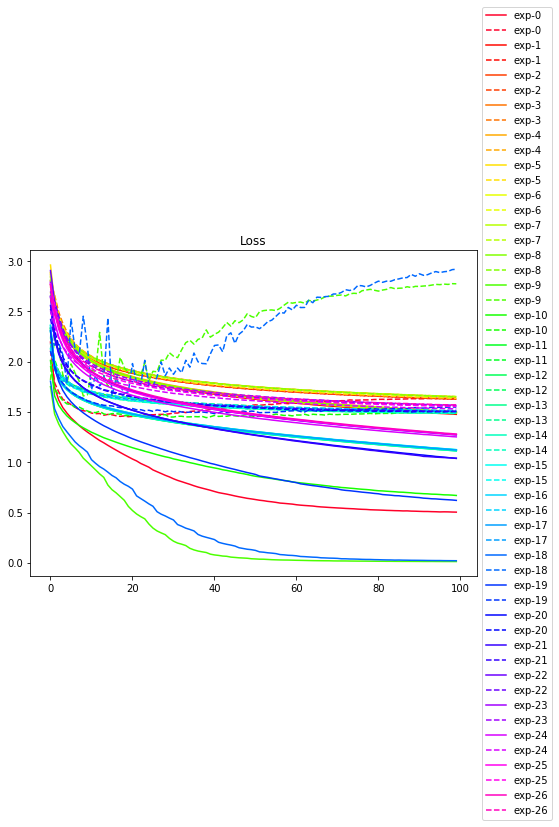

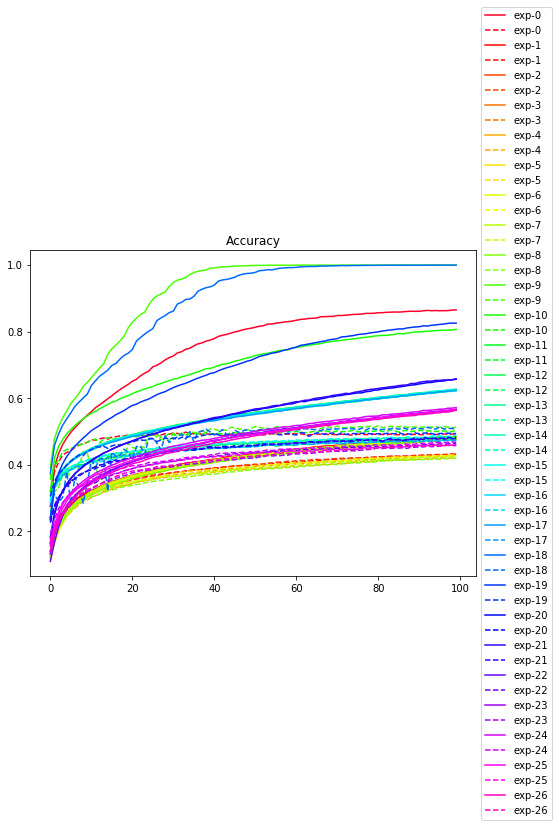

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()